In [1]:
import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
# Configure Plotly to be rendered inline in the notebook.

plotly.offline.init_notebook_mode(connected=True)

from tqdm import tqdm

import os
import sys
import re
import gc
from numba import jit
from collections import Counter
from collections import namedtuple
from collections import defaultdict

from sklearn.covariance import OAS
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import EmpiricalCovariance

import tensorflow as tf

from umap import UMAP
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, MiniBatchDictionaryLearning as DL, NMF, FastICA as ICA 
from sklearn.decomposition import FactorAnalysis as FA, SparsePCA as SPCA

from omic_helpers import omic_helpers as hlp


from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as HB
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn.neural_network import MLPRegressor as mlpr
from sklearn.svm import SVC

from xgboost import XGBRegressor as xgbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, HuberRegressor, ARDRegression
from pygam import GAM, LinearGAM, ExpectileGAM, s, f, l, te
from ngboost import NGBRegressor as ngbr
from ngboost.distns import LogNormal, Normal,Bernoulli
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE
from pyearth import Earth
from interpret.glassbox import ExplainableBoostingRegressor as ebr
from interpret import show as eb_show

from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence
from shap import TreeExplainer, force_plot, dependence_plot, summary_plot, KernelExplainer, LinearExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import AffinityPropagation

from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/p

In [2]:
# Load gene list
genes = pd.read_csv('../../_meta_data/gene_types/selected_genes.csv', sep='\t')
genes.Symbol = genes.Symbol.str.upper()

In [3]:
os.chdir('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/')

We start with RNA expression, methylation and DNA mutations separately.

The differentiation targets are the treatment response, the cancer types and the tissue type.

We use :

* statistical difference
* geometric difference
* multivariate classification

# Load data

In [4]:
# RNA 
# Methylation
# mutation
# Load meta data: immunoresponse, age, gender

dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

miRNA = pd.read_csv('Lung_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv("Lung_Proteome.txt", sep="\t")
proteome = proteome.set_index('sample').transpose()

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

In [5]:
granzyms = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('(GZM)|(SECT)|(PRF)')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'granzyms'} for _int in granzyms])
genes = pd.concat([genes, tmp])

In [6]:
interferons = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('IFN')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'interferon'} for _int in interferons])
genes = pd.concat([genes, tmp])

In [7]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 'stage 1', 'stage ia': 'stage 1', 'stage ib': 'stage 1',
             'stage ii': 'stage 2', 'stage iia': 'stage 2', 'stage iib': 'stage 2',
             'stage iii': 'stage 3','stage iiia': 'stage 3', 'stage iiib': 'stage 3',
             'stage iv' : 'stage 4'}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)
########
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Reponse To Therapy'].map(response_map)

meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))

In [8]:
dd['RNAex'].Gene = dd['RNAex'].Gene.str.upper()
RNAex = dd['RNAex'].to_pandas_df()
RNAex = RNAex.loc[RNAex.Gene.isin(genes.Symbol)]
RNAex.sort_values(by='Gene', inplace=True)
RNAex.Start = RNAex.Start.astype(str)
RNAex.Stop = RNAex.Stop.astype(str)
RNAex['rnaID'] = RNAex[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
rnamap = RNAex[['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
RNAex.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
RNAex = RNAex.set_index('rnaID').transpose()
gc.collect()

38804

In [9]:
low_var_list = RNAex.loc[:, rnamap['rnaID']].columns[RNAex.loc[:, rnamap['rnaID']].var()<0.05].tolist()
rnaID_include = list(set(rnamap.rnaID) - set(low_var_list))

In [10]:
dd['mutation'].Gene = dd['mutation'].Gene.str.upper()
mutation = dd['mutation'].to_pandas_df()
mutation = mutation.loc[mutation.Gene.isin(genes.Symbol)]
mutation.set_index('Sample_ID', inplace=True)
gc.collect()

5

In [11]:
dd['methylation'].Gene = dd['methylation'].Gene.str.upper()
methylation = dd['methylation'].to_pandas_df()
methylation = methylation.loc[methylation.Gene.isin(genes.Symbol)]
probemap = methylation[['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
probemap.reset_index(drop=True, inplace=True)
methylation.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1, inplace=True)
methylation = methylation.set_index('probeID').transpose()
gc.collect()

5

In [12]:
methylation_meta = dd['methylation_meta'].to_pandas_df()
methylation_meta = methylation_meta.loc[methylation_meta.IlmnID.isin(methylation.columns)]
gc.collect()

0

In [13]:
dd['CNV'].Gene = dd['CNV'].Gene.str.upper()
CNV = dd['CNV'].to_pandas_df()
CNV = CNV.loc[CNV.Gene.isin(genes.Symbol)]
CNV.Start = CNV.Start.astype(str)
CNV.Stop = CNV.Stop.astype(str)
CNV.Start.fillna("nan", inplace=True)
CNV.Stop.fillna("nan", inplace=True)
CNV.Strand.fillna("nan", inplace=True)
CNV.Chr.fillna("nan", inplace=True)
CNV['cnvID'] = CNV[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
cnvmap = CNV[['cnvID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
cnvmap.reset_index(drop=True, inplace=True)
CNV.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
CNV = CNV.set_index('cnvID').transpose()
gc.collect()

5

## 1.1 RNA expression

In [14]:
# deal with with multicollinearity
# 1. replace collinear cliques
# 2. only keep exemplar features

In [15]:
RNAex = RNAex.join(meta[meta_cols])

The UMAP visualisation suggest that the cancer types are **clearly** separable using RNA expression data. 

In [16]:
# 3 class problem: LA+primary tumor, LSCC+primary tumor, normal tissue
def make_target(x):
    if (x[0]=='Lung Squamous Cell Carcinoma') and (x[1]=='Primary Tumor'):
        return 'LSCC-tumor'
    elif (x[0]=='Lung Adenocarcinoma') and (x[1]=='Primary Tumor'):
        return 'LA-tumor'
    elif (x[1]=='Solid Tissue Normal'):
        return 'normal-tissue'
        
RNAex['y'] = RNAex[['Diagnosis', 'Sample Type']].apply(lambda x: make_target(x), axis=1)

In [17]:
tmp = RNAex.dropna(subset=['y'])
X = tmp.loc[:, rnaID_include].values
X = StandardScaler().fit_transform(X)
Y = tmp['y'].values # pd.Categorical(RNAex['y'])
Y = LabelEncoder().fit(Y).transform(Y)

We remove multi-collinearity before we apply permutation analysis

In [18]:
aff_prop = AffinityPropagation(preference=-1500)
aff_prop.fit(X.T)
clusters = aff_prop.predict(X.T)
exemplars = aff_prop.cluster_centers_indices_
X = X[:,exemplars]
col_arr = np.array(rnaID_include)
cols = col_arr[exemplars]

In [19]:
print('Number of exemplars:', len(cols))

Number of exemplars: 131


In [20]:
clust_list = defaultdict(list)
for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
    _exemplar_column = col_arr[_exemplar_id]
    for jdx, _idx in enumerate(aff_prop.labels_):
        if idx == _idx: 
            clust_list[_exemplar_column].append(col_arr[jdx])

## 1.1.2 model permutation for survival

To explore whether the survival rate is distinguishable using UMAP-embeddings split the data by cancer type and sample type which seem to be the most discriminative.So we have four groups:
* Adeno normal
* Adeno tumor
* SCC normal
* SCC tumor

In [21]:
Adeno  = RNAex.loc[(RNAex.Diagnosis=='Lung Adenocarcinoma') 
                   & (RNAex['Sample Type']=='Primary Tumor')]
SCC = RNAex.loc[(RNAex.Diagnosis=='Lung Squamous Cell Carcinoma') 
                & (RNAex['Sample Type']=='Primary Tumor')]

ALL = RNAex.loc[(RNAex['Sample Type']=='Primary Tumor')]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Overall Survival Status 0, male')

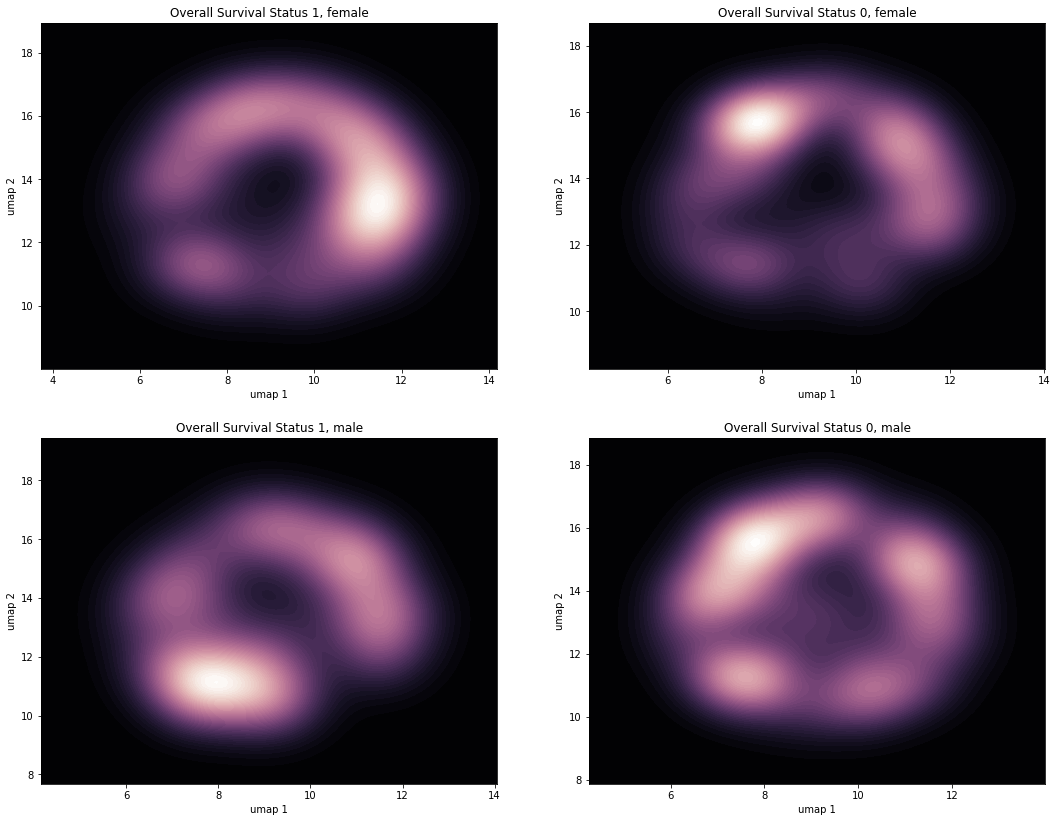

In [22]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets

_cols = cols  # rnaID_include

tmp = Adeno
diag_str = 'Adenocarcinoma Overall Survival Status'  # 'Lung Adenocarcinoma' 'Lung Squamous Cell Carcinoma', 'Adeno/SCC'

target = 'Overall Survival Status' # 'Overall Survival Status' # Response # Gender
tmp.dropna(subset=[target], axis=0, inplace=True)

red = 'UMAP'
reduceR = UMAP(n_components=3, random_state=323, n_neighbors=50) #UMAP(n_components=3)

scaler = StandardScaler().fit(tmp.loc[:, _cols])
X = scaler.transform(tmp.loc[:, _cols])

reduceR.fit(X) #  y=tmp['Response']


fig = go.Figure(layout={'title': diag_str+' RNA expression:'+red+' components'})
# Configure the trace.
reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==0), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0], 
    y=reduceD[:,1], 
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 1, Gender: male'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==0), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  
    y=reduceD[:,1],  
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 0, Gender: male'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==1), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0], 
    y=reduceD[:,1], 
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 1, Gender: female'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==1), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  
    y=reduceD[:,1],  
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 0, Gender: female'
)
)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
plotly.offline.iplot(fig)

##############
##############

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,14))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)


reduceR = UMAP(n_components=2, random_state=777, n_neighbors=50) #UMAP(n_components=3)
reduceR.fit(X)

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==1),
                                                               _cols])),
                   columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True,  ax=ax[0,0])
#ax[0,0].set_xlim(4, 15)
ax[0,0].set_title(target+' 1, female')

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==1), 
                                                                  _cols])),
                       columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True, ax=ax[0,1])
#ax[0,1].set_xlim(4, 15)
ax[0,1].set_title(target+' 0, female')

############

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==0),
                                                               _cols])),
                   columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True,  ax=ax[1,0])
#ax[1,0].set_xlim(4, 15)
ax[1,0].set_title(target+' 1, male')

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==0), 
                                                                  _cols])),
                       columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True, ax=ax[1,1])
#ax[1,1].set_xlim(4, 15)
ax[1,1].set_title(target+' 0, male')

In [23]:
# 4 class problem: LA/LSCC+survival/response, LA/LSCC+no survival/response
def make_target(x):
    if (x[0]=='Primary Tumor') and (x[1]==1):
        return 'deceased'
    elif (x[0]=='Primary Tumor') and (x[1]==0):
        return 'survived'   
    else:
        np.nan
        
RNAex['y'] = RNAex[['Sample Type' ,'Overall Survival Status']].apply(lambda x:
                                                                                 make_target(x), axis=1)
tmp = RNAex.dropna(subset=['y'])

In [24]:
with_meta = True

### Discriminating by survival status for Adenocarcinoma


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM
Getting permutation scores for RF


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


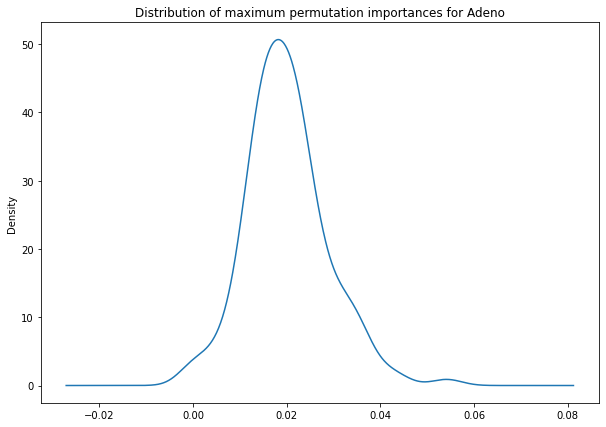

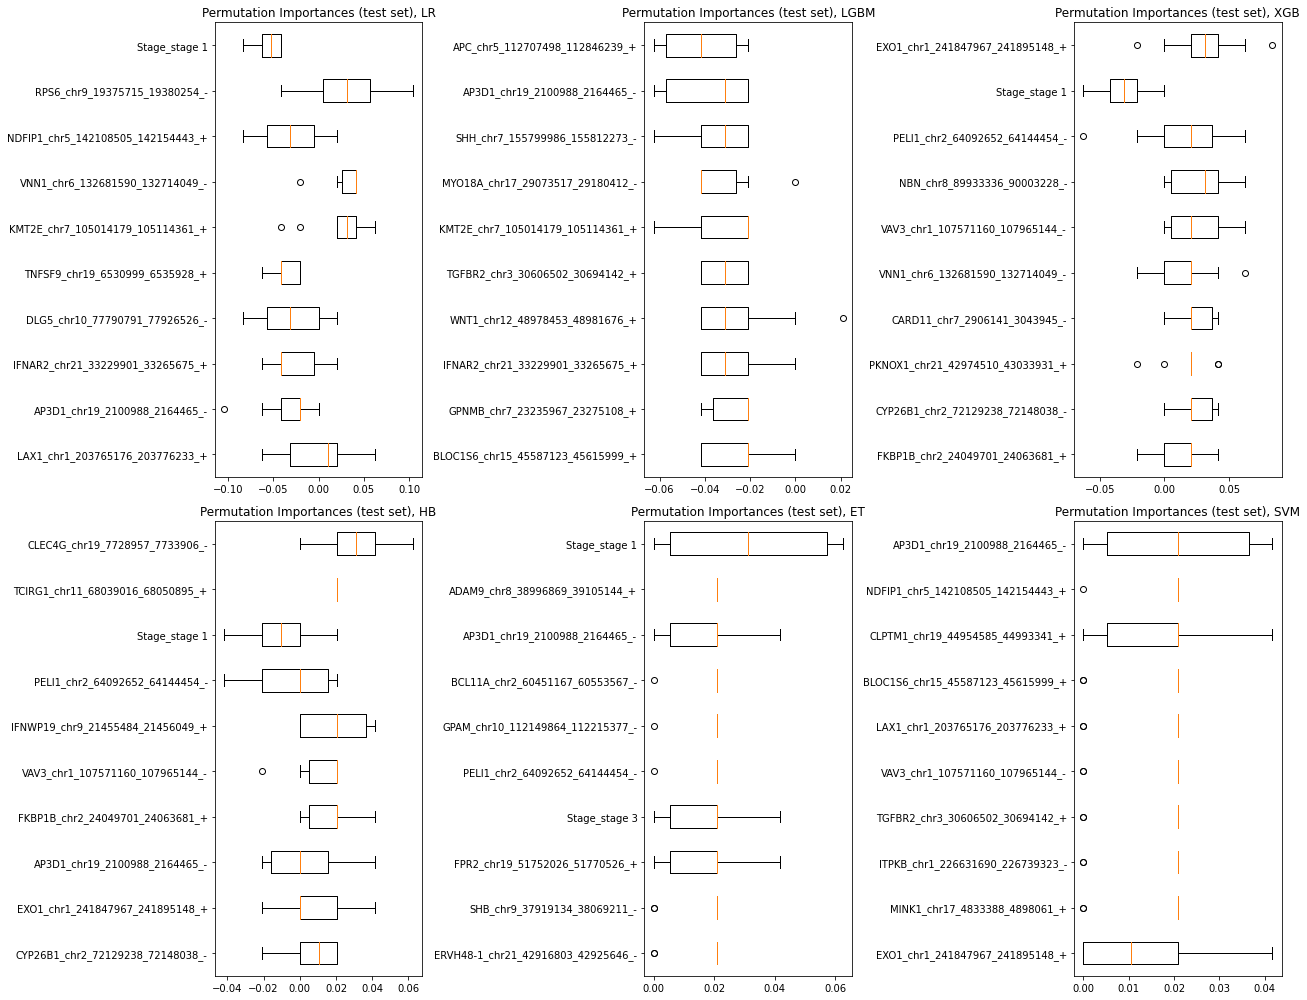

In [25]:
if with_meta:
    _cols = list(cols) + ['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage']
    tmp.dropna(subset=['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage'], inplace=True)
    _tmp = pd.get_dummies(tmp[_cols], columns=['Smoking', 'Stage'])
    _cols = np.array(_tmp.columns.tolist())
else:
    _tmp  = tmp[:, cols]
    _cols = cols

X_adeno = _tmp.loc[tmp.Diagnosis=='Lung Adenocarcinoma', :].values
X_adeno = StandardScaler().fit_transform(X_adeno)
Y_adeno = tmp.loc[tmp.Diagnosis=='Lung Adenocarcinoma', 'y'].values # pd.Categorical(RNAex['y'])
Y_adeno = LabelEncoder().fit(Y_adeno).transform(Y_adeno)

X_train, X_test, y_train, y_test = train_test_split(X_adeno, Y_adeno, 
                                                    random_state=123, stratify=Y_adeno, train_size=0.90)

models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.4),
          'SVM': SVC(C=0.9)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for Adeno")

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))


sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-10:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()



Setting feature_perturbation = "tree_path_dependent" because no background data was given.
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


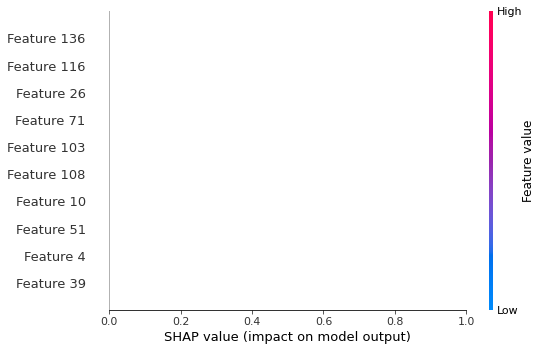

Make kernel explainer..
Get SHAP values..
Get summary of results


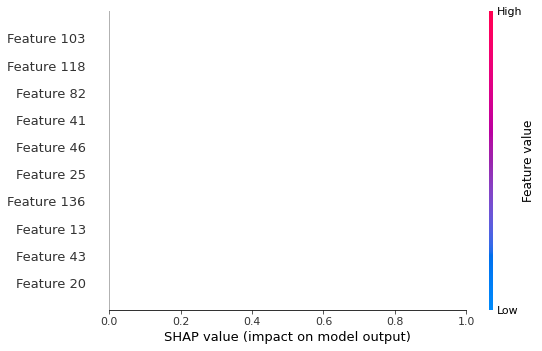

Make kernel explainer..
Get SHAP values..


INFO:MainThread:shap:num_full_subsets = 1
INFO:MainThread:shap:remaining_weight_vector = [0.11216374 0.07532164 0.0569066  0.04586251 0.03850397 0.03325155
 0.02931552 0.02625716 0.02381323 0.0218162  0.02015442 0.01875057
 0.01754943 0.0165105  0.01560342 0.01480497 0.01409708 0.0134655
 0.01289883 0.01238783 0.01192496 0.01150397 0.01111968 0.01076772
 0.0104444  0.01014657 0.00987155 0.00961702 0.00938097 0.00916164
 0.00895752 0.00876726 0.00858968 0.00842373 0.00826848 0.00812312
 0.00798689 0.00785915 0.0077393  0.0076268  0.00752118 0.00742201
 0.00732888 0.00724145 0.00715939 0.00708241 0.00701023 0.00694263
 0.00687938 0.00682027 0.00676512 0.00671377 0.00666606 0.00662186
 0.00658104 0.00654348 0.00650908 0.00647776 0.00644942 0.00642399
 0.0064014  0.00638161 0.00636455 0.00635019 0.00633849 0.00632942
 0.00632296 0.00631908 0.00631779]
INFO:MainThread:shap:num_paired_subset_sizes = 69
INFO:MainThread:shap:weight_left = 0.8173812018622241
l1_reg="auto" is deprecated and in t

INFO:MainThread:shap:num_full_subsets = 1
INFO:MainThread:shap:remaining_weight_vector = [0.11216374 0.07532164 0.0569066  0.04586251 0.03850397 0.03325155
 0.02931552 0.02625716 0.02381323 0.0218162  0.02015442 0.01875057
 0.01754943 0.0165105  0.01560342 0.01480497 0.01409708 0.0134655
 0.01289883 0.01238783 0.01192496 0.01150397 0.01111968 0.01076772
 0.0104444  0.01014657 0.00987155 0.00961702 0.00938097 0.00916164
 0.00895752 0.00876726 0.00858968 0.00842373 0.00826848 0.00812312
 0.00798689 0.00785915 0.0077393  0.0076268  0.00752118 0.00742201
 0.00732888 0.00724145 0.00715939 0.00708241 0.00701023 0.00694263
 0.00687938 0.00682027 0.00676512 0.00671377 0.00666606 0.00662186
 0.00658104 0.00654348 0.00650908 0.00647776 0.00644942 0.00642399
 0.0064014  0.00638161 0.00636455 0.00635019 0.00633849 0.00632942
 0.00632296 0.00631908 0.00631779]
INFO:MainThread:shap:num_paired_subset_sizes = 69
INFO:MainThread:shap:weight_left = 0.8173812018622241
l1_reg="auto" is deprecated and in t


Get summary of results


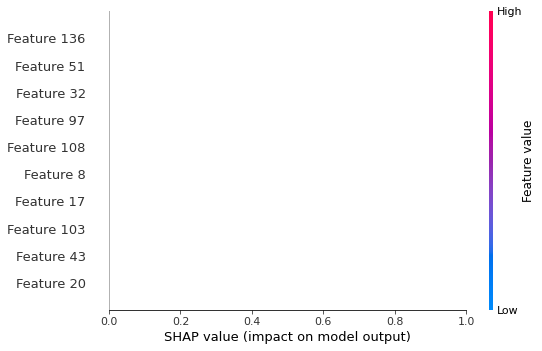

In [26]:
##############
##############
from shap import sample as shap_sample
from shap import kmeans as shap_kmeans

#fig, ax = plt.subplots(nrows=6, figsize=(14,20))

explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_adeno)
summary_plot(shap_values, X_adeno, max_display=10, plot_type='dots')

print("Make kernel explainer..")
explainer = LinearExplainer(models['LR'], X_adeno)
print("Get SHAP values..")
shap_values = explainer.shap_values(shap_sample(X_adeno, 400))
print("Get summary of results")
summary_plot(shap_values, X_adeno, max_display=10, plot_type='dots')

print("Make kernel explainer..")
explainer = KernelExplainer(models['SVM'].predict, X_adeno)
print("Get SHAP values..")
shap_values = explainer.shap_values(shap_sample(X_adeno, 5))
print("Get summary of results")
summary_plot(shap_values, X_adeno, max_display=10, plot_type='dots')

##############
##############

In [27]:
for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

Model:RF, Accuracy:0.5265654648956356
Model:XGB, Accuracy:0.555977229601518
Model:HB, Accuracy:0.5426944971537002
Model:ET, Accuracy:0.5426944971537002
Model:LGBM, Accuracy:0.5104364326375711
Model:LR, Accuracy:0.5180265654648957
Model:SVM, Accuracy:0.5265654648956356


### Discriminating by survival status for Squamous Cell Carcinoma

Fitting RF



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM
Getting permutation scores for RF


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET
Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


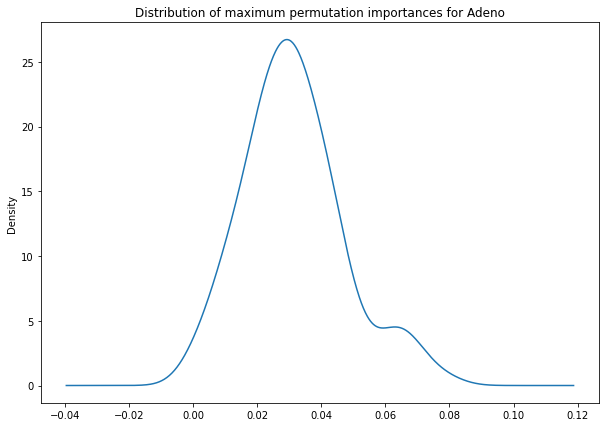

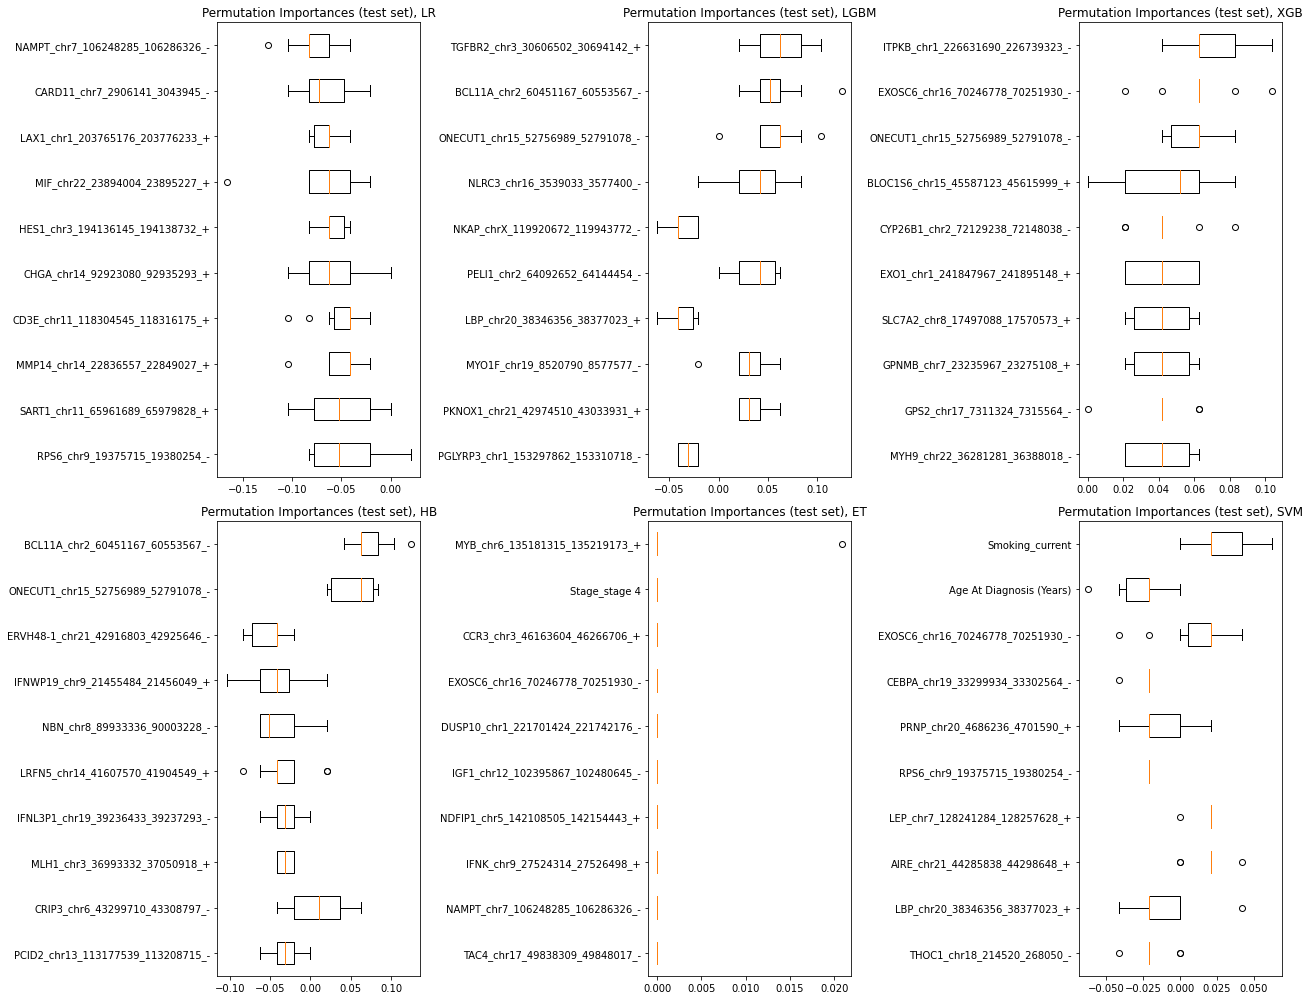

In [28]:
if with_meta:
    _cols = list(cols) + ['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage']
    tmp.dropna(subset=['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage'], inplace=True)
    _tmp = pd.get_dummies(tmp[_cols], columns=['Smoking', 'Stage'])
    _cols = np.array(_tmp.columns.tolist())
else:
    _cols = cols

X_scc = _tmp.loc[tmp.Diagnosis=='Lung Squamous Cell Carcinoma', :].values
X_scc = StandardScaler().fit_transform(X_scc)
Y_scc= tmp.loc[tmp.Diagnosis=='Lung Squamous Cell Carcinoma', 'y'].values # pd.Categorical(RNAex['y'])
Y_scc = LabelEncoder().fit(Y_scc).transform(Y_scc)

X_train, X_test, y_train, y_test = train_test_split(X_scc, Y_scc, 
                                                    random_state=123, stratify=Y_scc, train_size=0.90)

models = {'RF': RF(n_estimators=500, max_depth=4), 
          'XGB': xgb(n_estimators=500, max_depth=4), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000, max_depth=3),
          'LGBM': lgbm(n_estimators=500, max_depth=4),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for Adeno")

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))


sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-10:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


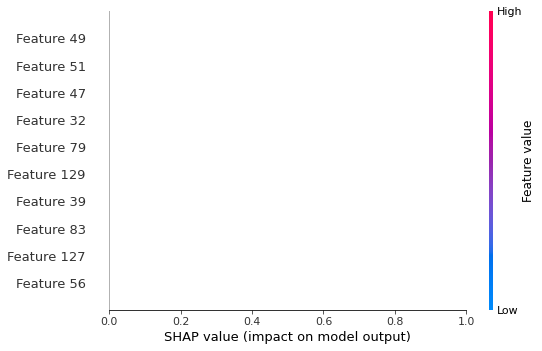

Make linear explainer..
Get SHAP values..
Get summary of results


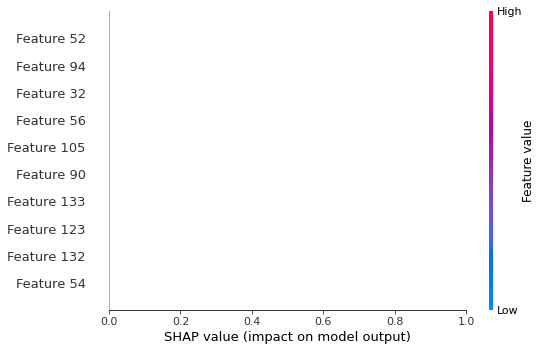

Make kernel explainer..


Get SHAP values..


INFO:MainThread:shap:num_full_subsets = 1
INFO:MainThread:shap:remaining_weight_vector = [0.11216374 0.07532164 0.0569066  0.04586251 0.03850397 0.03325155
 0.02931552 0.02625716 0.02381323 0.0218162  0.02015442 0.01875057
 0.01754943 0.0165105  0.01560342 0.01480497 0.01409708 0.0134655
 0.01289883 0.01238783 0.01192496 0.01150397 0.01111968 0.01076772
 0.0104444  0.01014657 0.00987155 0.00961702 0.00938097 0.00916164
 0.00895752 0.00876726 0.00858968 0.00842373 0.00826848 0.00812312
 0.00798689 0.00785915 0.0077393  0.0076268  0.00752118 0.00742201
 0.00732888 0.00724145 0.00715939 0.00708241 0.00701023 0.00694263
 0.00687938 0.00682027 0.00676512 0.00671377 0.00666606 0.00662186
 0.00658104 0.00654348 0.00650908 0.00647776 0.00644942 0.00642399
 0.0064014  0.00638161 0.00636455 0.00635019 0.00633849 0.00632942
 0.00632296 0.00631908 0.00631779]
INFO:MainThread:shap:num_paired_subset_sizes = 69
INFO:MainThread:shap:weight_left = 0.8173812018622241
l1_reg="auto" is deprecated and in t

INFO:MainThread:shap:num_full_subsets = 1
INFO:MainThread:shap:remaining_weight_vector = [0.11216374 0.07532164 0.0569066  0.04586251 0.03850397 0.03325155
 0.02931552 0.02625716 0.02381323 0.0218162  0.02015442 0.01875057
 0.01754943 0.0165105  0.01560342 0.01480497 0.01409708 0.0134655
 0.01289883 0.01238783 0.01192496 0.01150397 0.01111968 0.01076772
 0.0104444  0.01014657 0.00987155 0.00961702 0.00938097 0.00916164
 0.00895752 0.00876726 0.00858968 0.00842373 0.00826848 0.00812312
 0.00798689 0.00785915 0.0077393  0.0076268  0.00752118 0.00742201
 0.00732888 0.00724145 0.00715939 0.00708241 0.00701023 0.00694263
 0.00687938 0.00682027 0.00676512 0.00671377 0.00666606 0.00662186
 0.00658104 0.00654348 0.00650908 0.00647776 0.00644942 0.00642399
 0.0064014  0.00638161 0.00636455 0.00635019 0.00633849 0.00632942
 0.00632296 0.00631908 0.00631779]
INFO:MainThread:shap:num_paired_subset_sizes = 69
INFO:MainThread:shap:weight_left = 0.8173812018622241
l1_reg="auto" is deprecated and in t


Get summary of results


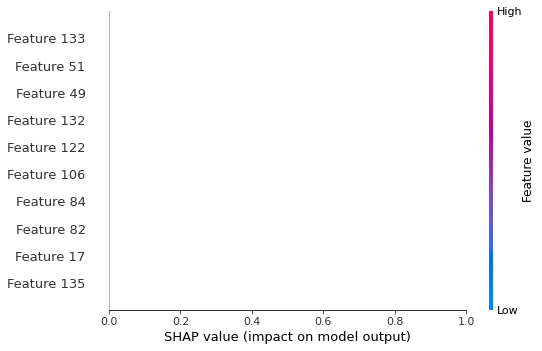

Model:RF, Accuracy:0.44179894179894175
Model:XGB, Accuracy:0.5105820105820106
Model:HB, Accuracy:0.5238095238095237
Model:ET, Accuracy:0.5
Model:LGBM, Accuracy:0.5423280423280423
Model:LR, Accuracy:0.582010582010582
Model:SVM, Accuracy:0.4365079365079365


In [29]:
##############
##############

explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_scc)
summary_plot(shap_values, X_scc, max_display=10, plot_type='dots')


print("Make linear explainer..")
explainer = LinearExplainer(models['LR'], X_scc)
print("Get SHAP values..")
shap_values = explainer.shap_values(shap_sample(X_scc, 400))
print("Get summary of results")
summary_plot(shap_values, X_scc, max_display=10, plot_type='dots')

print("Make kernel explainer..")
explainer = KernelExplainer(models['SVM'].predict, X_scc)
print("Get SHAP values..")
shap_values = explainer.shap_values(shap_sample(X_scc, 5))
print("Get summary of results")
summary_plot(shap_values, X_scc, max_display=10, plot_type='dots')


for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

### Discriminating for survival status on both sets together

Fitting RF



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM
Getting permutation scores for RF


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET
Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


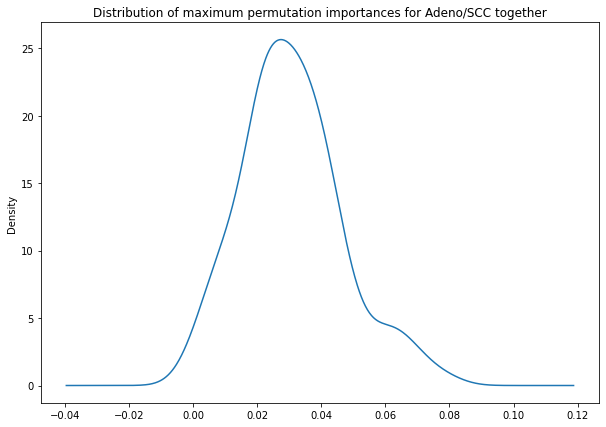

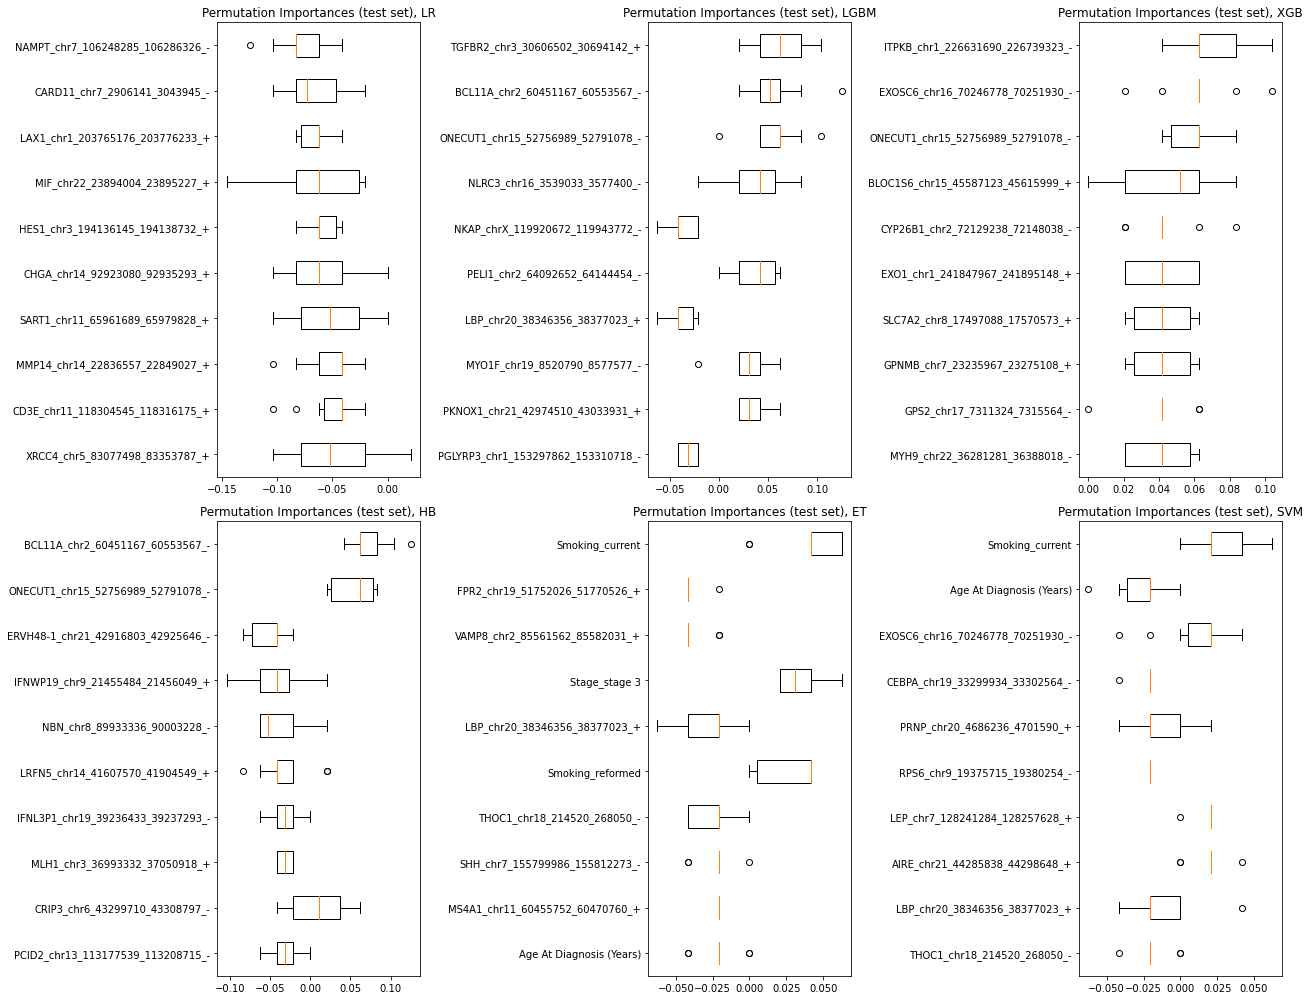

In [30]:
tmp = RNAex.dropna(subset=['y'])
if with_meta:
    _cols = list(cols) + ['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage']
    tmp.dropna(subset=['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage'], inplace=True)
    _tmp = pd.get_dummies(tmp[_cols], columns=['Smoking', 'Stage'])
    _cols = np.array(_tmp.columns.tolist())
else:
    _cols = cols

X_all = _tmp.loc[tmp.Diagnosis=='Lung Squamous Cell Carcinoma', :].values
X_all = StandardScaler().fit_transform(X_all)
Y_all= tmp.loc[tmp.Diagnosis=='Lung Squamous Cell Carcinoma', 'y'].values # pd.Categorical(RNAex['y'])
Y_all = LabelEncoder().fit(Y_all).transform(Y_all)

X_train, X_test, y_train, y_test = train_test_split(X_scc, Y_scc, 
                                                    random_state=123, stratify=Y_scc, train_size=0.90)

models = {'RF': RF(n_estimators=500,max_depth=4), 
          'XGB': xgb(n_estimators=500, max_depth=4), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000, max_depth=5),
          'LGBM': lgbm(n_estimators=500, max_depth=4),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for Adeno/SCC together")

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))


sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-10:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


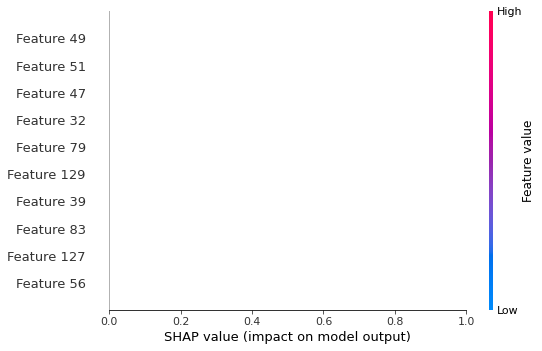

Make linear explainer..
Get SHAP values..
Get summary of results


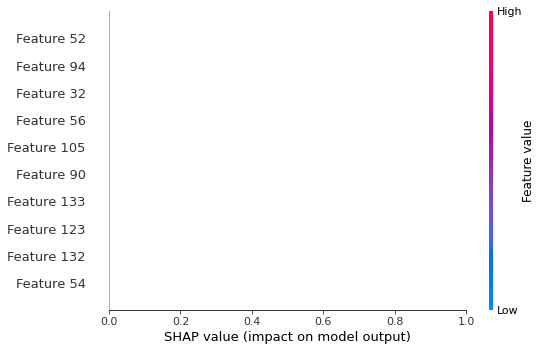

Model:RF, Accuracy:0.46031746031746035
Model:XGB, Accuracy:0.5105820105820106
Model:HB, Accuracy:0.5238095238095237
Model:ET, Accuracy:0.5476190476190477
Model:LGBM, Accuracy:0.5423280423280423
Model:LR, Accuracy:0.582010582010582
Model:SVM, Accuracy:0.4365079365079365


In [31]:
##############
##############

explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_all)
summary_plot(shap_values, X_all, max_display=10, plot_type='dots')


print("Make linear explainer..")
explainer = LinearExplainer(models['LR'], X_all)
print("Get SHAP values..")
shap_values = explainer.shap_values(shap_sample(X_all, 400))
print("Get summary of results")
summary_plot(shap_values, X_all, max_display=10, plot_type='dots')

#print("Make kernel explainer..")
#explainer = KernelExplainer(models['SVM'].predict, X_all)
#print("Get SHAP values..")
#shap_values = explainer.shap_values(shap_sample(X_all, 5))
#print("Get summary of results")
#summary_plot(shap_values, X_all, max_display=10, plot_type='dots')


for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

## 1.1.3 model permutation for time to event

How to use survival curves instead of the overall survival status? 

We cannot directly use the survival curves but we can apply use the ```Time To Event From Diagnosis (Days)``` to train a regressor.



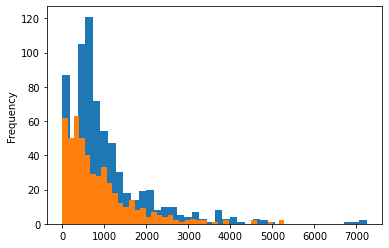

In [32]:
meta.loc[meta['Overall Survival Status']==0, 'Time To Overall Survival (Days)'].plot.hist(bins=40)
meta.loc[meta['Overall Survival Status']==1, 'Time To Overall Survival (Days)'].plot.hist(bins=40)

In [33]:
stage_map = {'stage 1': 1, 'stage 2': 2, 'stage 3': 3, 'stage 4': 4}
meta['Stage'] = meta.Stage.map(stage_map)
meta.dropna(subset=['Stage'], inplace=True)
meta['Stage'] = meta.Stage.astype(int)

Here a survival status of ```1``` actually means death, and ```0``` means survived. The time to overall survival is more the time to recovery for the survivors, and the time to death for the non-survivors. 

We need to make a choice, do we regress on the time-to-recovery or the time-to-death.
* time-to-recovery: for the non-survivors we should set the recovery time to a large number?
* time-to-death: for the survivors, we should set the time to death to a large number depending on their age?

**or** do we segment the data in survivors and deceasers, this avoids the issue of a non-realistic definition for the time to recovery/death. We choose for the latter and split the dataset.

In [34]:
pheno_features = ['Diagnosis', 'Sample Type', 
                  'Gender', 'Age At Diagnosis (Days)',
                  'Stage', 'Smoking', 'Time To Overall Survival (Days)']
patients_survived = meta.loc[meta['Overall Survival Status']==0, pheno_features]
patients_deceased = meta.loc[meta['Overall Survival Status']==1, pheno_features]

patients_survived['Age At Diagnosis (Days)'] = StandardScaler().fit_transform(patients_survived[['Age At Diagnosis (Days)']])
patients_deceased['Age At Diagnosis (Days)'] = StandardScaler().fit_transform(patients_deceased[['Age At Diagnosis (Days)']])

patients_survived.dropna(subset=pheno_features, inplace=True)
patients_deceased.dropna(subset=pheno_features, inplace=True)

patients_survived = patients_survived[pheno_features]
patients_deceased = patients_deceased[pheno_features]

In [35]:
patients_deceased = pd.get_dummies(patients_deceased, prefix='dummy_', columns=['Diagnosis', 
                                                                                'Sample Type', 'Smoking'])
patients_survived = pd.get_dummies(patients_survived, prefix='dummy_', columns=['Diagnosis', 
                                                                                'Sample Type', 'Smoking'])

In [36]:
tmp_cols = cols # cols, rnaID_include
rna_tmp = RNAex.loc[:, tmp_cols].dropna()

#rna_tmp  = pd.DataFrame(data=MinMaxScaler(feature_range=(-1,1)).fit_transform(rna_tmp),
#                        columns=tmp_cols)
rna_tmp  = pd.DataFrame(data=StandardScaler().fit_transform(rna_tmp),
                        columns=tmp_cols, index=rna_tmp.index)

X_deceased = patients_deceased.join(rna_tmp, how='inner')
X_survived = patients_survived.join(rna_tmp, how='inner')
_cols = np.array(X_deceased.columns.tolist())

y_deceased = X_deceased['Time To Overall Survival (Days)']
y_survived = X_survived['Time To Overall Survival (Days)']

X_deceased.drop('Time To Overall Survival (Days)', axis=1, inplace=True)
X_survived.drop('Time To Overall Survival (Days)', axis=1, inplace=True)

In [37]:
# show distribution of correlations with the regression target
# decide on cut-off

# do F-test

#### Time to survival 

In [38]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_survived, y_survived, 
                                                            random_state=421, train_size=0.8)

t_train = np.empty((X_s_train.shape[0]), dtype='object')
t_train[:] = 'train'
t_test = np.empty((X_s_test.shape[0]), dtype='object')
t_test[:] = 'test'

In [39]:
_cols = X_s_train.columns.tolist()
_cols= np.array(_cols)

In [40]:
# XGB, LGBM, SVR, NGB, GAM, Huber, ElasticNet, MARS
models = dict()
models['ebr'] = ebr()
models['huber'] = HuberRegressor()
models['enet'] = ElasticNet()
models['mars'] = Earth()
models['xgb'] = xgbr(n_estimators=200)
models['lgbm'] = lgbmr(n_estimators=200)
models['svr'] = SVR(kernel='linear') 

### GAM

In [41]:
models['gam'] = LinearGAM(s(1, constraints='monotonic_inc'))
# GAM builder: l (linear), s (spline), f (factor), te (tensor product), intercept
for idx, _type in enumerate(X_survived.dtypes):
        if 'int' in str(_type):
            models['gam'].terms += f(idx)
        elif 'float' in str(_type):
            models['gam'].terms += s(idx) # 'concave', monotonic_inc
            #models['gam'].terms += te(2,idx)
            
models['gam'].fit(X_s_train, y_s_train)
gam_res = pd.DataFrame(data=np.vstack([np.hstack([models['gam'].predict(X_s_test), 
                                                  models['gam'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
gam_res[gam_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
gam_res[gam_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
gam_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=gam_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(gam_res[gam_res['type']=='test']['pred'], gam_res[gam_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(gam_res[gam_res['type']=='test']['pred'], gam_res[gam_res['type']=='test']['truth']),
      "R2:", r2_score(gam_res['pred'], gam_res['truth']))
gc.collect()

ValueError: cannot set WRITEABLE flag to True of this array

In [ ]:
gc.collect()

### EBR

In [ ]:
models['ebr'].fit(X_s_train, y_s_train)
ebr_res = pd.DataFrame(data=np.vstack([np.hstack([models['ebr'].predict(X_s_test), 
                                                  models['ebr'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ebr_res[ebr_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
ebr_res[ebr_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
ebr_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=ebr_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(ebr_res[ebr_res['type']=='test']['pred'], ebr_res[ebr_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(ebr_res[ebr_res['type']=='test']['pred'], ebr_res[ebr_res['type']=='test']['truth']),
      "R2:", r2_score(ebr_res['pred'], ebr_res['truth']))

ebr_global = models['ebr'].explain_global(name='EBR')
eb_show(ebr_global)

### Huber and ElasticNet

In [ ]:
models['huber'].fit(X_s_train, y_s_train)
huber_res = pd.DataFrame(data=np.vstack([np.hstack([models['huber'].predict(X_s_test), 
                                                  models['huber'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
huber_res[huber_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
huber_res[huber_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
huber_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=huber_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(huber_res[huber_res['type']=='test']['pred'], huber_res[huber_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(huber_res[huber_res['type']=='test']['pred'], huber_res[huber_res['type']=='test']['truth']),
      "R2:", r2_score(huber_res['pred'], huber_res['truth']))

In [ ]:
models['enet'].fit(X_s_train, y_s_train)
enet_res = pd.DataFrame(data=np.vstack([np.hstack([models['enet'].predict(X_s_test), 
                                                  models['enet'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
enet_res[enet_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
enet_res[enet_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
enet_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=enet_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(enet_res[enet_res['type']=='test']['pred'], enet_res[enet_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(enet_res[enet_res['type']=='test']['pred'], enet_res[enet_res['type']=='test']['truth']),
      "R2:", r2_score(enet_res['pred'], enet_res['truth']))

### MARS

In [ ]:
models['mars'].fit(X_s_train, y_s_train)
mars_res = pd.DataFrame(data=np.vstack([np.hstack([models['mars'].predict(X_s_test), 
                                                  models['mars'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
mars_res[mars_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
mars_res[mars_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
mars_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=mars_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(mars_res[mars_res['type']=='test']['pred'], mars_res[mars_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(mars_res[mars_res['type']=='test']['pred'], mars_res[mars_res['type']=='test']['truth']),
      "R2:", r2_score(mars_res['pred'], mars_res['truth']))

### XGB

In [ ]:
models['xgb'].fit(X_s_train, y_s_train)
xgb_res = pd.DataFrame(data=np.vstack([np.hstack([models['xgb'].predict(X_s_test), 
                                                  models['xgb'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
xgb_res[xgb_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
xgb_res[xgb_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
xgb_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=xgb_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(xgb_res[xgb_res['type']=='test']['pred'], xgb_res[xgb_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(xgb_res[xgb_res['type']=='test']['pred'], xgb_res[xgb_res['type']=='test']['truth']),
      "R2:", r2_score(xgb_res['pred'], xgb_res['truth']))

### LGBM

In [ ]:
models['lgbm'].fit(X_s_train, y_s_train)
lgbm_res = pd.DataFrame(data=np.vstack([np.hstack([models['lgbm'].predict(X_s_test), 
                                                  models['lgbm'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
lgbm_res[lgbm_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
lgbm_res[lgbm_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
lgbm_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=lgbm_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(lgbm_res[lgbm_res['type']=='test']['pred'], lgbm_res[lgbm_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(lgbm_res[lgbm_res['type']=='test']['pred'], lgbm_res[lgbm_res['type']=='test']['truth']),
      "R2:", r2_score(lgbm_res['pred'], lgbm_res['truth']))

### NGBoost

In [ ]:
models['ngb'] = ngbr(Base=default_tree_learner, 
                     Dist=Normal, Score=MLE, 
                     natural_gradient=True, verbose=False) # LogNormal, Bernoulli, Normal
models['ngb'].fit(X_s_train, y_s_train)
ngb_res = pd.DataFrame(data=np.vstack([np.hstack([models['ngb'].predict(X_s_test), 
                                                  models['ngb'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ngb_res[ngb_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
ngb_res[ngb_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
ngb_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=ngb_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(ngb_res[ngb_res['type']=='test']['pred'], ngb_res[ngb_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(ngb_res[ngb_res['type']=='test']['pred'], ngb_res[ngb_res['type']=='test']['truth']),
      "R2:", r2_score(ngb_res['pred'], ngb_res['truth']))

### SVR

In [ ]:
models['svr'].fit(X_s_train, y_s_train)
svr_res = pd.DataFrame(data=np.vstack([np.hstack([models['svr'].predict(X_s_test), 
                                                  models['svr'].predict(X_s_train)]),
                                       np.hstack([y_s_test.values, y_s_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
svr_res[svr_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True, ax=ax[0])
svr_res[svr_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True, ax=ax[0])
svr_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=svr_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MSE:", mean_squared_error(svr_res[svr_res['type']=='test']['pred'], svr_res[svr_res['type']=='test']['truth']),
      "MAE:", mean_absolute_error(svr_res[svr_res['type']=='test']['pred'], svr_res[svr_res['type']=='test']['truth']),
      "R2:", r2_score(svr_res['pred'], svr_res['truth']))

### Permutation scores

In [ ]:
perm_result = dict()
print("Getting permutation scores for MARS")
perm_result['mars'] = permutation_importance(models['mars'], X_s_test, y_s_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['xgb'] = permutation_importance(models['xgb'], X_s_test, y_s_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['lgbm'] = permutation_importance(models['lgbm'], X_s_test, y_s_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for Huber")
perm_result['huber'] = permutation_importance(models['huber'], X_s_test, y_s_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for Elastic Net")
perm_result['enet'] = permutation_importance(models['enet'], X_s_test, y_s_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVR")
perm_result['svr'] = permutation_importance(models['svr'], X_s_test, y_s_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for NGBoost")
perm_result['ngb'] = permutation_importance(models['ngb'], X_s_test, y_s_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for EBR")
perm_result['ebr'] = permutation_importance(models['ebr'], X_s_test, y_s_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['mars'].importances).mean(axis=1),
           np.abs(perm_result['xgb'].importances).mean(axis=1),
           np.abs(perm_result['lgbm'].importances).mean(axis=1),
           np.abs(perm_result['huber'].importances).mean(axis=1),      
           np.abs(perm_result['enet'].importances).mean(axis=1),
           np.abs(perm_result['svr'].importances).mean(axis=1),
           np.abs(perm_result['ngb'].importances).mean(axis=1),
           np.abs(perm_result['ebr'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['MARS', 'XGB', 'LGBM', 'Huber',
                                                           'Enet', 'SVR', 'NGB', 'EBR'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for time to survival")


In [ ]:
fig, ax = plt.subplots(nrows=8, figsize=(10,28))
sorted_idx = np.abs(perm_result['mars'].importances).mean(axis=1).argsort()[-10:]
ax[0].boxplot(perm_result['mars'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0].set_title("Permutation Importances (test set), MARS")

sorted_idx = np.abs(perm_result['xgb'].importances).mean(axis=1).argsort()[-10:]
ax[1].boxplot(perm_result['xgb'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1].set_title("Permutation Importances (test set), XGB")

sorted_idx = np.abs(perm_result['lgbm'].importances).mean(axis=1).argsort()[-10:]
ax[2].boxplot(perm_result['lgbm'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[2].set_title("Permutation Importances (test set), LGBM")

sorted_idx = np.abs(perm_result['huber'].importances).mean(axis=1).argsort()[-10:]
ax[3].boxplot(perm_result['huber'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[3].set_title("Permutation Importances (test set), Huber")

sorted_idx = np.abs(perm_result['enet'].importances).mean(axis=1).argsort()[-10:]
ax[4].boxplot(perm_result['enet'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[4].set_title("Permutation Importances (test set), Elastic Net")

sorted_idx = np.abs(perm_result['svr'].importances).mean(axis=1).argsort()[-10:]
ax[5].boxplot(perm_result['svr'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[5].set_title("Permutation Importances (test set), SVR")

sorted_idx = np.abs(perm_result['ngb'].importances).mean(axis=1).argsort()[-10:]
ax[6].boxplot(perm_result['ngb'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[6].set_title("Permutation Importances (test set), NGB")

sorted_idx = np.abs(perm_result['ebr'].importances).mean(axis=1).argsort()[-10:]
ax[7].boxplot(perm_result['ebr'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[7].set_title("Permutation Importances (test set), EBR")


In [ ]:
#gam_terms = models['gam'].terms
#feature_idx=42
#XX = models['gam'].generate_X_grid(term=feature_idx)
#pdep, confi = models['gam'].partial_dependence(term=feature_idx, X=XX, width=0.95)

#plt.figure()
#plt.plot(XX[:, gam_terms[feature_idx].feature], pdep)
#plt.plot(XX[:, gam_terms[feature_idx].feature], confi, c='r', ls='--')
#plt.title(_cols[feature_idx])
#plt.show()

In [ ]:
clust_list['ERVV-1_chr19_53013921_53016122_+'] 

In [ ]:
# do some SHAP stuff here

explainer = TreeExplainer(models['xgb'])
shap_values = explainer.shap_values(X_s_train)
summary_plot(shap_values, X_s_train)

explainer = TreeExplainer(models['lgbm'])
shap_values = explainer.shap_values(X_s_train)
summary_plot(shap_values, X_s_train)

explainer = LinearExplainer(models['enet'], data=X_s_train)
shap_values = explainer.shap_values(X_s_train)
summary_plot(shap_values, X_s_train)

explainer = LinearExplainer(models['huber'], data=X_s_train)
shap_values = explainer.shap_values(X_s_train)
summary_plot(shap_values, X_s_train)

#### Time to death

In [ ]:
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_deceased, y_deceased, 
                                                            random_state=413, train_size=0.8)

t_train = np.empty((X_d_train.shape[0]), dtype='object')
t_train[:] = 'train'
t_test = np.empty((X_d_test.shape[0]), dtype='object')
t_test[:] = 'test'

_cols = X_d_train.columns.tolist()
_cols= np.array(_cols)

# XGB, LGBM, SVR, NGB, GAM, Huber, ElasticNet, MARS
models = dict()
models['ebr'] = ebr()
models['huber'] = HuberRegressor()
models['enet'] = ElasticNet()
models['mars'] = Earth()
models['xgb'] = xgbr(n_estimators=200)
models['lgbm'] = lgbmr(n_estimators=200)
models['ngb'] = ngbr() # LogNormal, Bernoulli, Normal
models['svr'] = SVR(kernel='linear') 

In [ ]:
# GAM builder: l (linear), s (spline), f (factor), te (tensor product), intercept
models['gam'] = LinearGAM(s(0, constraints='monotonic_inc'), verbose=1)
for idx, _type in enumerate(X_d_train.dtypes):
        if 'int' in str(_type):
            models['gam'].terms += f(idx)
        elif 'float' in str(_type):
            models['gam'].terms += s(idx, n_splines=10) # 'concave', monotonic_inc
            
models['gam'].fit(X_d_train, y_d_train)
#models['gam'].gridsearch(X_deceased, y_deceased)
gam_res = pd.DataFrame(data=np.vstack([np.hstack([models['gam'].predict(X_d_test), 
                                                  models['gam'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
gam_res[gam_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
gam_res[gam_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
gam_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=gam_res, x='truth', y='pred', hue='type', alpha=0.5)

print("GAM MSE:", mean_squared_error(ebr_res['pred'], ebr_res['truth']),
      "GAM MAE:", mean_absolute_error(ebr_res['pred'], ebr_res['truth']),
      "GAM R2:", r2_score(ebr_res['pred'], ebr_res['truth']))

In [ ]:
models['ebr'].fit(X_d_train, y_d_train)
ebr_res = pd.DataFrame(data=np.vstack([np.hstack([models['ebr'].predict(X_d_test), 
                                                  models['ebr'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ebr_res[ebr_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
ebr_res[ebr_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
ebr_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=ebr_res, x='truth', y='pred', hue='type', alpha=0.5)

print("EBR MSE:", mean_squared_error(ebr_res['pred'], ebr_res['truth']),
      "EBR MAE:", mean_absolute_error(ebr_res['pred'], ebr_res['truth']),
      "EBR R2:", r2_score(ebr_res['pred'], ebr_res['truth']))

ebr_global = models['ebr'].explain_global(name='EBR')
eb_show(ebr_global)

In [ ]:
models['huber'].fit(X_d_train, y_d_train)
huber_res = pd.DataFrame(data=np.vstack([np.hstack([models['huber'].predict(X_d_test), 
                                                  models['huber'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
huber_res[huber_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
huber_res[huber_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
huber_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=huber_res, x='truth', y='pred', hue='type', alpha=0.5)

print("Huber MSE:", mean_squared_error(huber_res['pred'], huber_res['truth']),
      "Huber MAE:", mean_absolute_error(huber_res['pred'], huber_res['truth']),
      "Huber R2:", r2_score(huber_res['pred'], huber_res['truth']))



In [ ]:
models['enet'].fit(X_d_train, y_d_train)
enet_res = pd.DataFrame(data=np.vstack([np.hstack([models['enet'].predict(X_d_test), 
                                                  models['enet'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
enet_res[enet_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
enet_res[enet_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
enet_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=enet_res, x='truth', y='pred', hue='type', alpha=0.5)

print("ElasticNet MSE:", mean_squared_error(enet_res['pred'], enet_res['truth']),
      "ElasticNet MAE:", mean_absolute_error(enet_res['pred'], enet_res['truth']),
      "ElasticNet R2:", r2_score(enet_res['pred'], enet_res['truth']))

In [ ]:
models['mars'].fit(X_d_train, y_d_train)
mars_res = pd.DataFrame(data=np.vstack([np.hstack([models['mars'].predict(X_d_test), 
                                                  models['mars'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
mars_res[mars_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
mars_res[mars_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
mars_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=mars_res, x='truth', y='pred', hue='type', alpha=0.5)

print("MARS MSE:", mean_squared_error(mars_res['pred'], mars_res['truth']),
      "MARS MAE:", mean_absolute_error(mars_res['pred'], mars_res['truth']),
      "MARS R2:", r2_score(mars_res['pred'], mars_res['truth']))

In [ ]:
models['xgb'].fit(X_d_train, y_d_train)
xgb_res = pd.DataFrame(data=np.vstack([np.hstack([models['xgb'].predict(X_d_test), 
                                                  models['xgb'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
xgb_res[xgb_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
xgb_res[xgb_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
xgb_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=xgb_res, x='truth', y='pred', hue='type', alpha=0.5)

print("XGB MSE:", mean_squared_error(xgb_res['pred'], xgb_res['truth']),
      "XGB MAE:", mean_absolute_error(xgb_res['pred'], xgb_res['truth']),
      "XGB R2:", r2_score(xgb_res['pred'], xgb_res['truth']))

In [ ]:
models['lgbm'].fit(X_d_train, y_d_train)
lgbm_res = pd.DataFrame(data=np.vstack([np.hstack([models['lgbm'].predict(X_d_test), 
                                                  models['lgbm'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
lgbm_res[lgbm_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
lgbm_res[lgbm_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
lgbm_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=lgbm_res, x='truth', y='pred', hue='type', alpha=0.5)

print("LGBM MSE:", mean_squared_error(lgbm_res['pred'], lgbm_res['truth']),
      "LGBM MAE:", mean_absolute_error(lgbm_res['pred'], lgbm_res['truth']),
      "LGBM R2:", r2_score(lgbm_res['pred'], lgbm_res['truth']))

In [ ]:
models['ngb'].fit(X_d_train, y_d_train)
ngb_res = pd.DataFrame(data=np.vstack([np.hstack([models['ngb'].predict(X_d_test), 
                                                  models['ngb'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ngb_res[ngb_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True,
                                                    ax=ax[0])
ngb_res[ngb_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True,
                                                   ax=ax[0])
ngb_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=ngb_res, x='truth', y='pred', hue='type', alpha=0.5)

print("NGB MSE:", mean_squared_error(ngb_res['pred'], ngb_res['truth']),
      "NGB MAE:", mean_absolute_error(ngb_res['pred'], ngb_res['truth']),
      "NGB R2:", r2_score(ngb_res['pred'], ngb_res['truth']))

In [ ]:
models['svr'].fit(X_d_train, y_d_train)
svr_res = pd.DataFrame(data=np.vstack([np.hstack([models['svr'].predict(X_d_test), 
                                                  models['svr'].predict(X_d_train)]),
                                       np.hstack([y_d_test.values, y_d_train.values]),
                                       np.hstack([t_test, t_train])]).T, 
                       columns=['pred', 'truth', 'type'])


fig, ax = plt.subplots(ncols=2, figsize=(14,7))
svr_res[svr_res['type']=='train']['pred'].plot.hist(bins=20, histtype='step', label='train pred',  density=True, ax=ax[0])
svr_res[svr_res['type']=='test']['pred'].plot.hist(bins=20, histtype='step', label='test pred', density=True, ax=ax[0])
svr_res['truth'].plot.hist(bins=20, alpha=0.5, density=True, ax=ax[0])
ax[0].legend()


sns.scatterplot(data=svr_res, x='truth', y='pred', hue='type', alpha=0.5)

print("SVR MSE:", mean_squared_error(svr_res['pred'], svr_res['truth']),
      "SVR MAE:", mean_absolute_error(svr_res['pred'], svr_res['truth']),
      "SVR R2:", r2_score(svr_res['pred'], svr_res['truth']))

In [ ]:
perm_result = dict()
print("Getting permutation scores for MARS")
perm_result['mars'] = permutation_importance(models['mars'], X_d_test, y_d_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['xgb'] = permutation_importance(models['xgb'], X_d_test, y_d_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['lgbm'] = permutation_importance(models['lgbm'], X_d_test, y_d_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for Huber")
perm_result['huber'] = permutation_importance(models['huber'], X_d_test, y_d_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for Elastic Net")
perm_result['enet'] = permutation_importance(models['enet'], X_d_test, y_d_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVR")
perm_result['svr'] = permutation_importance(models['svr'], X_d_test, y_d_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for NGBoost")
perm_result['ngb'] = permutation_importance(models['ngb'], X_d_test, y_d_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for EBR")
perm_result['ebr'] = permutation_importance(models['ebr'], X_d_test, y_d_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['mars'].importances).mean(axis=1),
           np.abs(perm_result['xgb'].importances).mean(axis=1),
           np.abs(perm_result['lgbm'].importances).mean(axis=1),
           np.abs(perm_result['huber'].importances).mean(axis=1),      
           np.abs(perm_result['enet'].importances).mean(axis=1),
           np.abs(perm_result['svr'].importances).mean(axis=1),
           np.abs(perm_result['ngb'].importances).mean(axis=1),
           np.abs(perm_result['ebr'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['MARS', 'XGB', 'LGBM', 'Huber',
                                                           'Enet', 'SVR', 'NGB', 'EBR'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for time to death")


In [ ]:
fig, ax = plt.subplots(nrows=8, figsize=(10,28))
sorted_idx = np.abs(perm_result['mars'].importances).mean(axis=1).argsort()[-10:]
ax[0].boxplot(perm_result['mars'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0].set_title("Permutation Importances (test set), MARS")

sorted_idx = np.abs(perm_result['xgb'].importances).mean(axis=1).argsort()[-10:]
ax[1].boxplot(perm_result['xgb'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1].set_title("Permutation Importances (test set), XGB")

sorted_idx = np.abs(perm_result['lgbm'].importances).mean(axis=1).argsort()[-10:]
ax[2].boxplot(perm_result['lgbm'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[2].set_title("Permutation Importances (test set), LGBM")

sorted_idx = np.abs(perm_result['huber'].importances).mean(axis=1).argsort()[-10:]
ax[3].boxplot(perm_result['huber'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[3].set_title("Permutation Importances (test set), Huber")

sorted_idx = np.abs(perm_result['enet'].importances).mean(axis=1).argsort()[-10:]
ax[4].boxplot(perm_result['enet'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[4].set_title("Permutation Importances (test set), Elastic Net")

sorted_idx = np.abs(perm_result['svr'].importances).mean(axis=1).argsort()[-10:]
ax[5].boxplot(perm_result['svr'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[5].set_title("Permutation Importances (test set), SVR")

sorted_idx = np.abs(perm_result['ngb'].importances).mean(axis=1).argsort()[-10:]
ax[6].boxplot(perm_result['ngb'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[6].set_title("Permutation Importances (test set), NGB")

sorted_idx = np.abs(perm_result['ebr'].importances).mean(axis=1).argsort()[-10:]
ax[7].boxplot(perm_result['ebr'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[7].set_title("Permutation Importances (test set), EBR")

In [ ]:
explainer = TreeExplainer(models['xgb'])
shap_values = explainer.shap_values(X_d_train)
summary_plot(shap_values, X_d_train)

In [ ]:
explainer = TreeExplainer(models['lgbm'])
shap_values = explainer.shap_values(X_d_train)
summary_plot(shap_values, X_d_train)

In [ ]:
explainer = TreeExplainer(models['ngb'])
shap_values = explainer.shap_values(X_d_train)
summary_plot(shap_values, X_d_train)

In [ ]:
explainer = LinearExplainer(models['enet'], data=X_d_train)
shap_values = explainer.shap_values(X_d_train)
summary_plot(shap_values, X_d_train)

In [ ]:
explainer = LinearExplainer(models['huber'], data=X_d_train)
shap_values = explainer.shap_values(X_d_train)
summary_plot(shap_values, X_d_train)

In [ ]:
#gam_terms = models['gam'].terms
#feature_idx=42
#XX = models['gam'].generate_X_grid(term=feature_idx)
#pdep, confi = models['gam'].partial_dependence(term=feature_idx, X=XX, width=0.95)

#plt.figure()
#plt.plot(XX[:, gam_terms[feature_idx].feature], pdep)
#plt.plot(XX[:, gam_terms[feature_idx].feature], confi, c='r', ls='--')
#plt.title(_cols[feature_idx])
#plt.show()

### Statistical differencing between target groups

KS+WASS

#### Survival curve impact analysis

To compare the impact of the features on the survival curves we perform a differential analysis based on the median-splits using monotonically extrapolated Kaplan-Meier curves and aggregate survival curve values.

We use both the time-to-survival as the time-to-death.

First, we note that the hazard rate can be written as 
$$
h = -\frac{1}{S}\frac{dS}{dt}
$$

Where $S$ is the survival probability before some time $t$.